# Description
Divide mock catalog into different density environments and find the power spectrum for each of these subsamples. Preparation for investigating relativistic effects as cross correlation between subsamples needed.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.special import legendre
from scipy.integrate import simpson
from scipy.linalg import pinv
import scipy.sparse as ss

import cat_power_algos as catpk
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu') # matter power spectrum 

kmin, kmax, dk = 0, 0.25, 0.01
Nmesh = 128

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): w0_fld, wa_fld
  self.engine = ClassEngine(pars)


### Preparation
Load BGS catalog and split into density bins. Then compute the multipoles $l=0,2$ for each bin. Stored as columns in `Pk_ells`.

In [4]:
%%time
print("Loading catalog")
filepath = '/disk11/salam/FirstGenMocks/AbacusSummit/CubicBox/BGS_v2/z0.200/AbacusSummit_base_c000_ph006/BGS_box_ph006.fits'
cat = FITSCatalog(filepath)
cat = catpk.prep_fitscat(cat, cosmo=cosmo, LOS=LOS, z=redshift)
mesh = cat.to_mesh(position='RSDPosition', resampler='tsc', BoxSize=BoxSize, Nmesh=Nmesh, compensated=True)

print("Loading density data")
filepath_density = '/disk11/salam/FirstGenMocks/AbacusSummit/CubicBox/BGS_v2/z0.200/AbacusSummit_base_c000_ph006/BGS_box_ph006.vtf_mean.fits.gz'
fits = fitsio.FITS(filepath_density)

# Split into 10 percentiles
print("Splitting density data into percentiles")
ptile_split = np.percentile(fits[1]['rho'][:], [0,10,20,30,40,50,60,70,80,90,100]) # gets edges of density bins

Loading catalog
Loading density data
Splitting density data into percentiles
CPU times: user 2min 49s, sys: 3min 31s, total: 6min 20s
Wall time: 6min 52s


In [5]:
ells = [0,2]
n_ptile = len(ptile_split)-1 # number of bins = number of edges - 1
Pk_ells = np.empty((n_ptile, len(ells)), dtype='object') # each column contains multipole of all percentiles

for i in range(n_ptile):
    t1 = time.time()
    # get indcies of i-th percentile
    insel = fits[1].where('rho>%f && rho<=%f'%(ptile_split[i],ptile_split[i+1]))
        
    mesh = cat[insel].to_mesh(position='RSDPosition', resampler='tsc', BoxSize=BoxSize, Nmesh=Nmesh, compensated=True)
    poles = FFTPower(mesh, mode='2d', los=LOS, poles=ells, kmin=kmin, kmax=kmax, dk=dk).poles
    
    for j,ell in enumerate(ells):
        Pk_ell = poles['power_%d' %ell].real
        if ell == 0: 
            Pk_ell = Pk_ell - poles.attrs['shotnoise']
            
        Pk_ells[i][j] = Pk_ell

    t2 = time.time()
    print("Completed percentile {:d} in {:.2f} sec".format(i+1, t2-t1))
    
k = poles['k']
shotnoise = poles.attrs['shotnoise']

Completed percentile 1 in 253.31 sec
Completed percentile 2 in 178.53 sec
Completed percentile 3 in 181.72 sec
Completed percentile 4 in 126.20 sec
Completed percentile 5 in 179.45 sec
Completed percentile 6 in 133.26 sec
Completed percentile 7 in 110.64 sec
Completed percentile 8 in 113.59 sec
Completed percentile 9 in 111.52 sec
Completed percentile 10 in 133.67 sec


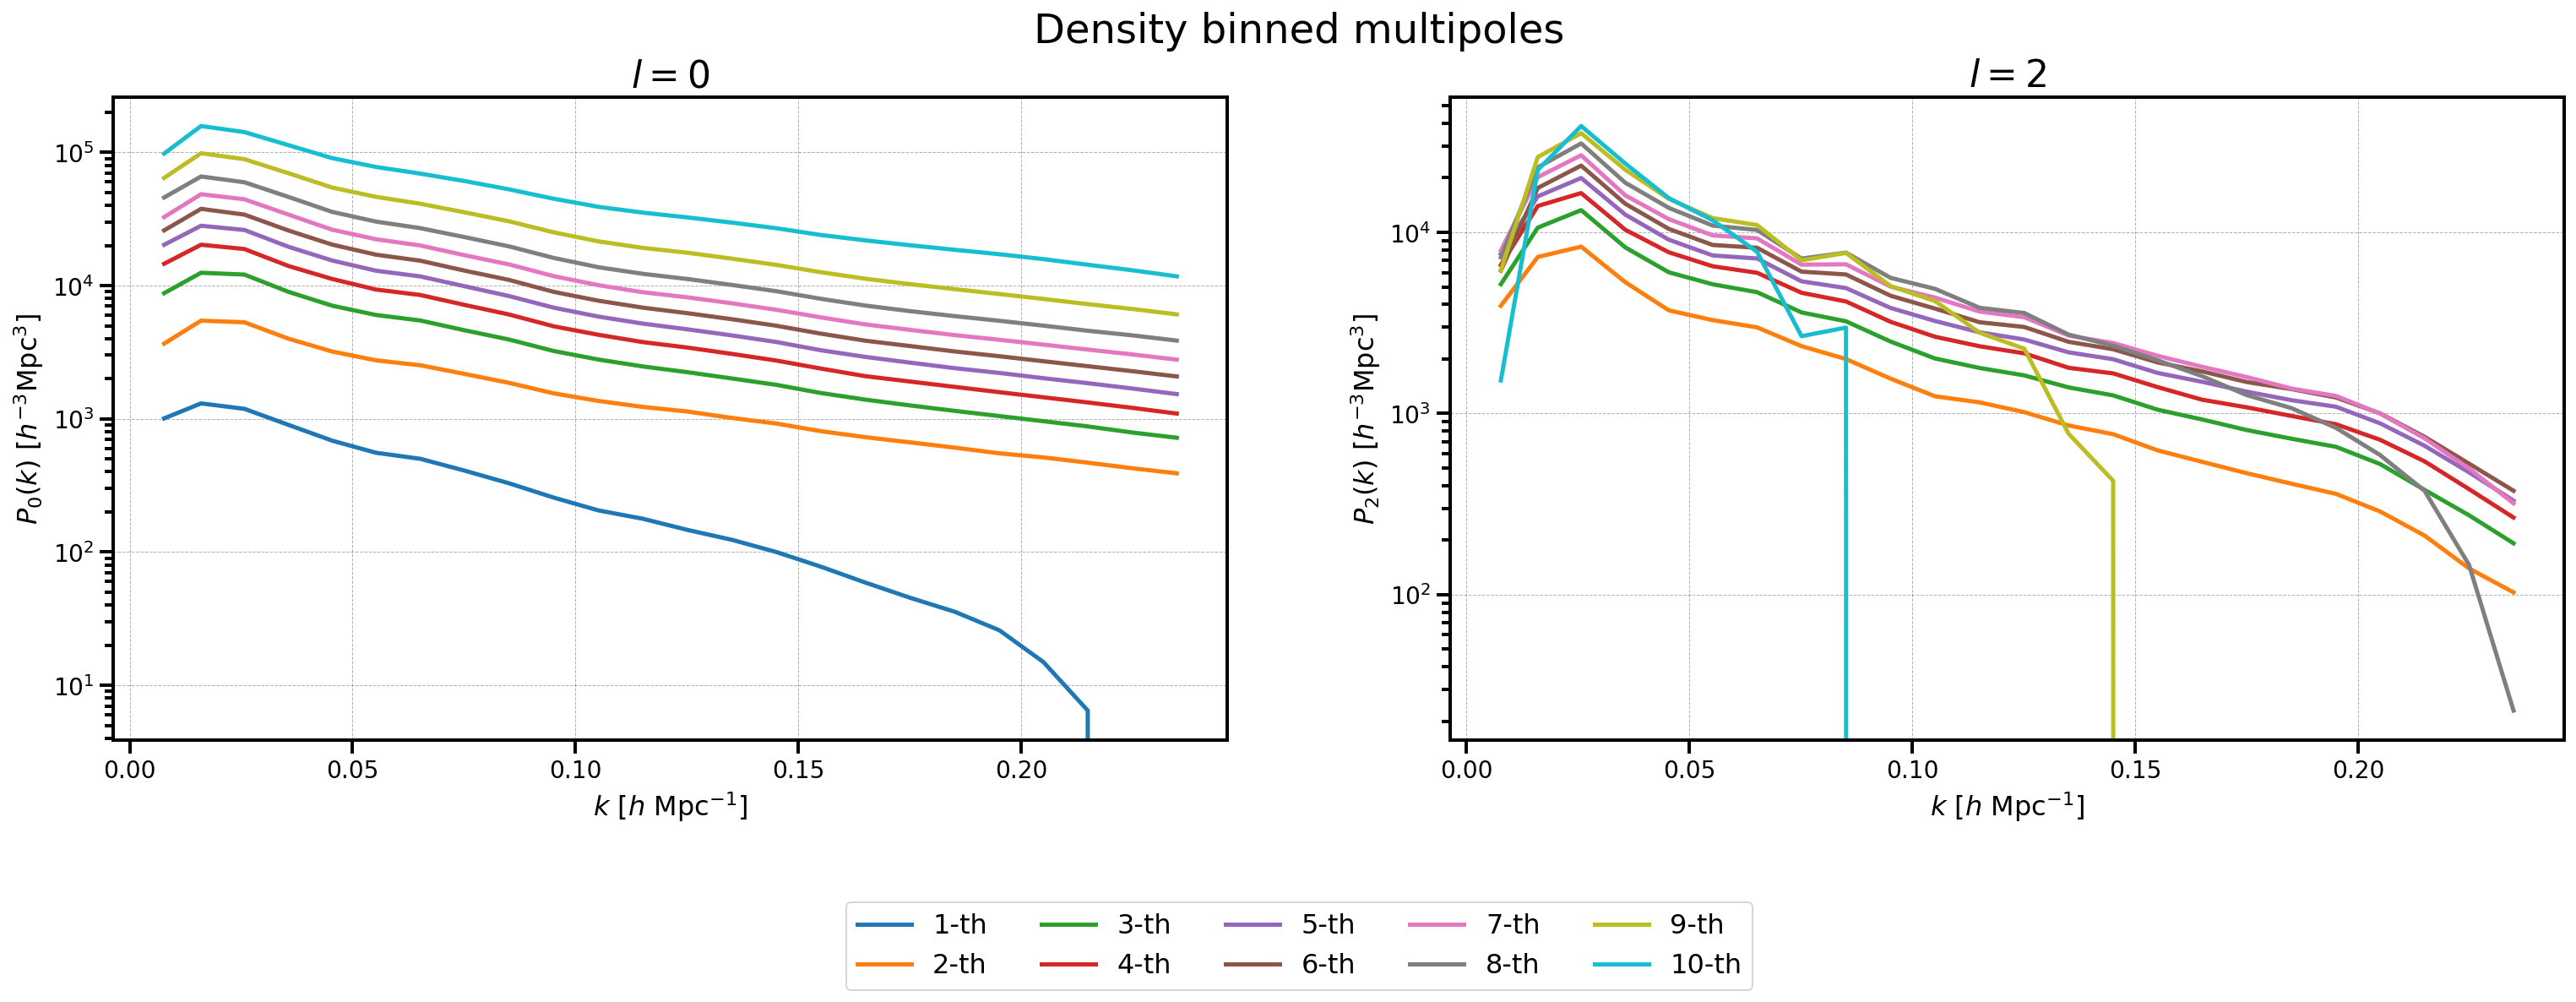

In [6]:
fig, axs = plt.subplots(1, len(ells), figsize=(26,7))

for j, ell in enumerate(ells):
    for i in range(n_ptile):
        axs[j].plot(k, Pk_ells[i][j], label='%d-th'%(i+1))
        
    #axs[j].set_title("Density separated multipole $l=%d$"%ell)
    axs[j].set_title("$l=%d$"%ell)
    axs[j].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    axs[j].set_ylabel(r"$P_%d(k)$ [$h^{-3}\mathrm{Mpc}^3$]"%ell)
    axs[j].set_yscale('log')
    
fig.suptitle('Density binned multipoles', fontsize=24)
handles, labels = axs[j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.show()
#fig.savefig("plots/multipoles_densities_binned.pdf")

### Interpretation
As the density increases, the power spectrum amplitude increases such that a larger value of `b1` will be necessary when fitting the linear theory prediction.

### Fit b1 and beta for each density bin and multipole
Fitting $\beta$ is effectively the same as fitting the growth rate $f$ at $z=0$ as $\beta \equiv \frac{f_0}{b1}$.
Fitting procedure is analogous to Fitting_b1 notebook but now having 2 free parameters. The linear theory predictions for the multipoles are (eq 5.7 in Hamilton's review):

$$
P_0^s(k) = (1 + \frac{2}{3}\beta + \frac{1}{5}\beta^2 )P(k), \quad P_2^s(k) = ( \frac{4}{3}\beta + \frac{4}{7}\beta^2 )P(k)
$$

where the real space power spectrum $P(k)$ is related to the matter power spectrum $P_m(k)$ via $P(k) = b1^2P_m(k)$. Note that in the Fitting_b1 notebook, these multipoles have not been hardcoded but computed by projection on Legendre polynomials. 

In [7]:
def make_Pkmu(k, b1, beta):
    '''Make 2D array containing the model P(k,mu) with rows iterating k bins and columns iterating mu bins.
    Later seek to integrate up each row i.e. integrate over mu. Nmu defines the discretiation.'''
    Nmu = 51
    mus = np.linspace(-1,1,Nmu)
    Pkmu = np.empty((len(k), Nmu))
    
    for i,mu in enumerate(mus):
        Pkmu[:,i] = (1 + beta*mu**2)**2 *b1**2 * Plin(k)
        
    return Pkmu, mus


def per_mode_cov(k, l1, l2, b1, beta, shotnoise, dk):
    '''Construct per mode covariance. See eq 15, 16 (for factor f) of Grieb et al. (2016).'''
    V = BoxSize**3
    V_k = 4/3*np.pi*((k+dk/2)**3 - (k-dk/2)**3)
    f = 2*(2*np.pi)**4 / V_k**2 * k**2 * dk
    Pkmu, mus = make_Pkmu(k, b1, beta)
    L_l1, L_l2 = legendre(l1)(mus), legendre(l2)(mus)
    integrand = (Pkmu + shotnoise)**2 * L_l1*L_l2
    
    return f*(2*l1+1)**2 * (2*l2+1)**2 / V * simpson(integrand, mus) # 1D array containing per mode cov for each k bin


def gaussian_cov_mat_inv(k, ells, b1, beta, shotnoise, dk):
    '''See above markdown for explanation of structure of covariance matrix. Uses sparse matricies for fast inversion.
    scipy.sparse.bmat allows to combine matricies by passing structure of larger matrix in terms of submatricies.'''
    # initialize array accepting matricies as elements and fill with diagonal C_l1,l2 matricies
    C = np.empty((len(ells), len(ells)), dtype='object')
    for i,l1 in enumerate(ells):
        for j,l2 in list(enumerate(ells))[i:]:
            C[i][j] = ss.diags(per_mode_cov(k,l1,l2,b1,beta,shotnoise,dk))
            if j!=i:
                C[j][i] = C[i][j]
                
    cov_mat = ss.bmat(C).tocsc() # convert to efficient scipy matrix format
    
    # deal with inverting signular matrix
    try: 
        inv = ss.linalg.inv(cov_mat).toarray()
    except RuntimeError:
        inv = pinv(cov_mat.toarray())
        
    return inv
    
    
def chi2(x, k, data_multipoles, shotnoise, dk):
    '''Find chi^2 as explained in Fitting_b1.ipynb. data_multipoles must be an array of shape (len(ells), len(k)).
    x is an array containing the parameters to be fitted: x = [b1, beta].
    Due to hard coding multipoles, only works for ells = [0,2]'''
    b1, beta = x[0], x[1]
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    C_inv = gaussian_cov_mat_inv(k, ells, b1, beta, shotnoise, dk)
    
    return D_M@(C_inv @ D_M)

In [22]:
b1_fits, beta_fits, chi2_mins = np.empty(n_ptile), np.empty(n_ptile), np.empty(n_ptile)

for i in range(n_ptile):
    t1 = time.time()
    # change data format of Pk_ells to be compatible with chi2 minimization code 
    # slices k upto k=0.1 to mainly probe linear regime
    upper = 8
    data_multipoles = np.empty((len(ells), len(k[:upper])))
    data_multipoles[0] = Pk_ells[i][0][:upper]
    data_multipoles[1] = Pk_ells[i][1][:upper]
    s = minimize(chi2, [1, 0.5], args=(k[:upper], data_multipoles, shotnoise, dk), bounds=((0, None), (0, None)))
    b1_fits[i] = s.x[0]
    beta_fits[i] = s.x[1]
    chi2_mins[i] = s.fun
    t2 = time.time()
    print("Fitted %d-th percentile in %.2f sec"%(i+1,t2-t1))

Fitted 1-th percentile in 1.07 sec
Fitted 2-th percentile in 2.21 sec
Fitted 3-th percentile in 1.49 sec
Fitted 4-th percentile in 1.41 sec
Fitted 5-th percentile in 1.07 sec
Fitted 6-th percentile in 1.03 sec
Fitted 7-th percentile in 1.16 sec
Fitted 8-th percentile in 1.32 sec
Fitted 9-th percentile in 1.32 sec
Fitted 10-th percentile in 1.34 sec


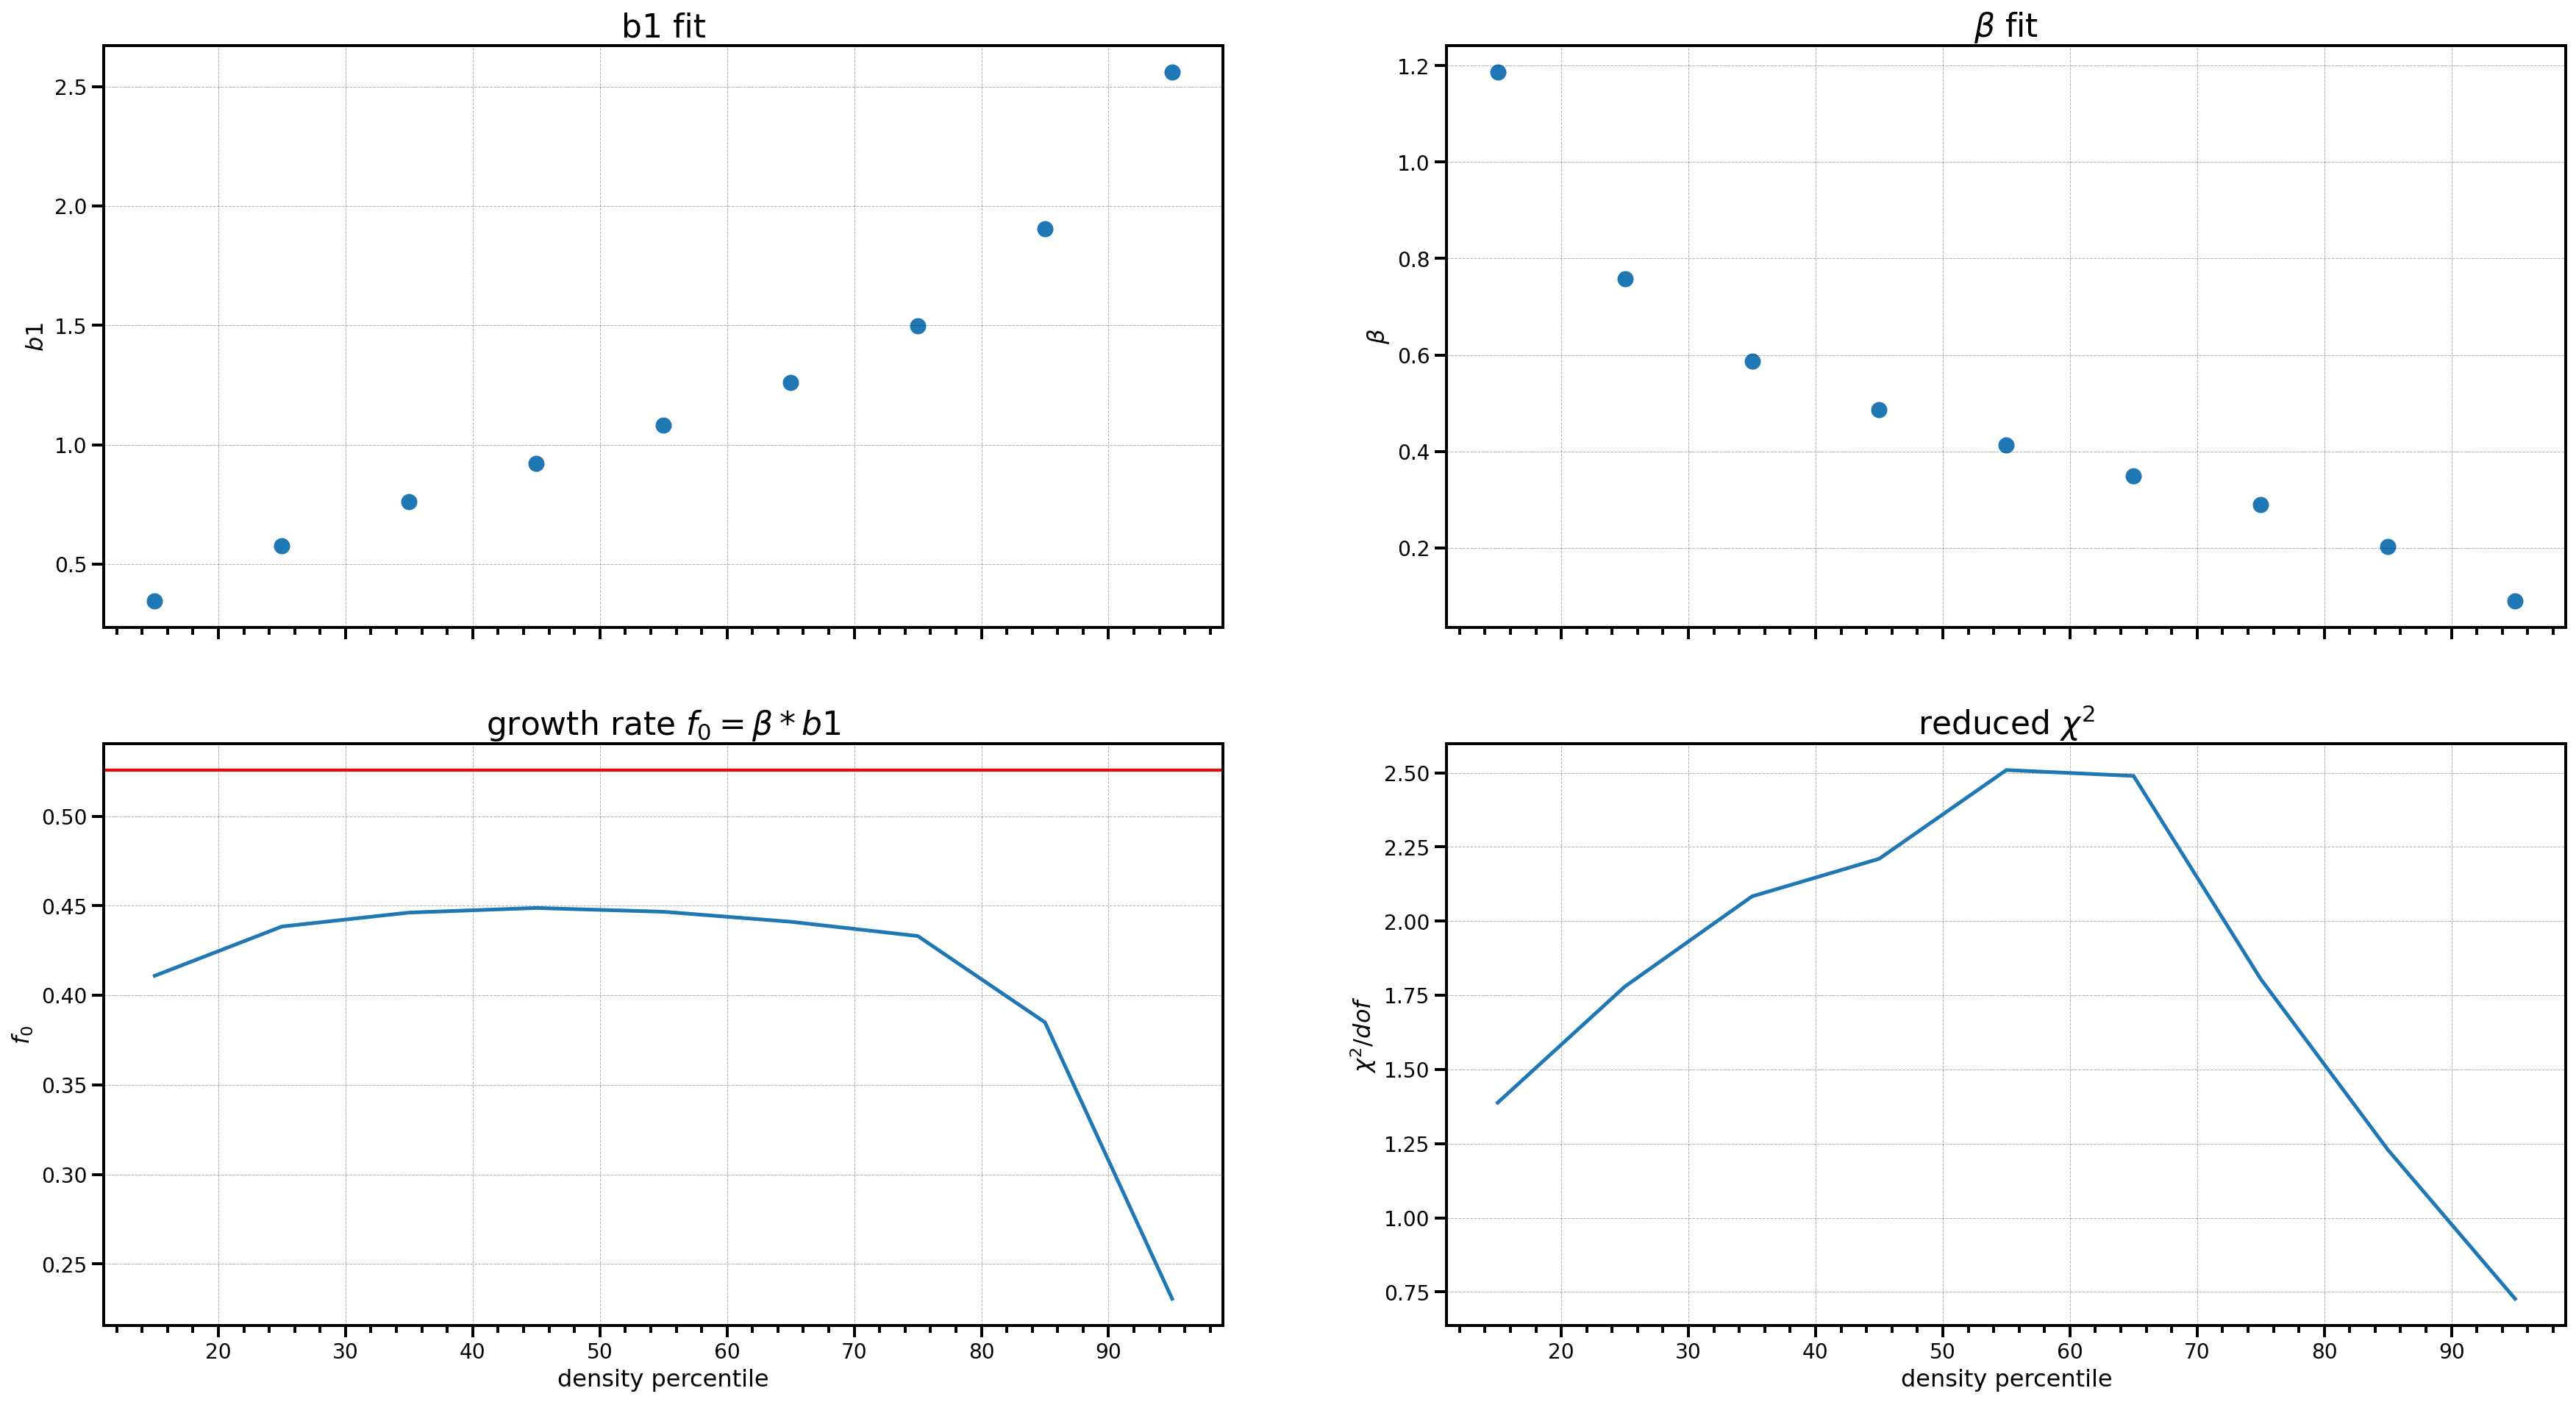

In [25]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10)[1:] # percentile mid points

axs[0][0].scatter(mids, b1_fits[1:])
axs[0][0].set_title("b1 fit")
#axs[0][0].set_xlabel("density percentile")
axs[0][0].set_ylabel(r"$b1$")

axs[0][1].scatter(mids, beta_fits[1:])
axs[0][1].set_title(r"$\beta$ fit")
#axs[0][1].set_xlabel("density percentile")
axs[0][1].set_ylabel(r"$\beta$")

axs[1][0].plot(mids, (beta_fits*b1_fits)[1:])
axs[1][0].axhline(y=cosmo.scale_independent_growth_rate(redshift), c='r', linewidth=2)
axs[1][0].set_title(r"growth rate $f_0 = \beta *b1$")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$f_0$")
#axs[1][0].set_ylim(ymin=-2.5, ymax=0.8)
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())

# For each of l=0,2 we have data_multipoles.shape[1] k bins. Fitting two parameters gives DOF
reduced_chi2 = chi2_mins/(2*data_multipoles.shape[1] - 2)
axs[1][1].plot(mids, reduced_chi2[1:])
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins.pdf')